# Exploring Boston Neighborhoods

## Introduction

The Greater Boston Metro area is one of the most expensive places to live in the United States. As the tenth largest metropolitan statistical area in the US, Boston is home to a continuously growing population of approximately 4.8 million people.  This growth is driven by both general global urbanization trends as well as a thriving economy — particularly in the fields of education, technology, and biotech. Demand for housing has exploded over the past decade and is also aided by the annual turnover in student populations. All of these factors contribute to a high median home value of approximately $630,000.

Given the high cost to enter the Boston real estate market, most people — whether professional real estate investors or individuals looking to diversify their investment holdings or purchase a home — want to know as much as possible before they purchase. Trying to find a deal in the city is difficult, but can be aided by looking in areas that are cheaper but also have the desired surrounding amenities and venues.

This project aims to discover more information about Bostonian zip codes and the most popular venues within each. Additionally it will look at the possibility of segmenting, classifying, and modeling the median prices of the neighborhood.

## Import libraries and API variables

In [1]:
#dataframe and geojson manipulation
import pandas as pd
import geopandas as gpd

#api requests
import requests

#plot visualization
import seaborn as sns
import matplotlib.pyplot as plt

#map vizualization
import folium
import branca.colormap as cm

#read/write files
import csv

#classification and modeling
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

#statistical testing
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#import api keys/secrets for foursquare and google geocodes
import os
from dotenv import load_dotenv
load_dotenv()
google_key = os.getenv('google_key')
client_id = os.getenv('foursquare_client')
client_secret = os.getenv('foursquare_secret')

## Real Estate Information

Begin importing real estate segmented by zip code from zillow.

In [2]:
#read csv into df
df = pd.read_csv('zipcode_data.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,233265.0,...,1248340.0,1234262.0,1229890.0,1226466.0,1208024.0,1182758.0,1150900.0,1134880.0,1120949.0,1112549.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,211748.0,...,494425.0,493485.0,492514.0,491726.0,491562.0,492618.0,494017.0,494766.0,494546.0,494435.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,245773.0,...,1161916.0,1153259.0,1156287.0,1175142.0,1193746.0,1205413.0,1203165.0,1209735.0,1211403.0,1212520.0
3,91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,200430.0,...,336121.0,336159.0,336142.0,336234.0,335959.0,336153.0,336611.0,337678.0,338602.0,339179.0
4,84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,286382.0,...,646296.0,645348.0,643973.0,642628.0,642209.0,642227.0,642454.0,641440.0,640355.0,639311.0


The information is clearly nationwide, so we will begin narrowing it down to the areas we will be examining. 

In [3]:
#select for MA to avoid duplicates
mass = df[df['State'] == 'MA']
mass.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
87,58669,89,2169,Zip,MA,MA,Quincy,Boston-Cambridge-Newton,Norfolk County,133987.0,...,470278.0,472710.0,475028.0,479331.0,482411.0,485023.0,485869.0,485722.0,485742.0,482662.0
167,58660,171,2148,Zip,MA,MA,Malden,Boston-Cambridge-Newton,Middlesex County,133788.0,...,491282.0,491954.0,492978.0,493827.0,496507.0,498268.0,501183.0,502993.0,504573.0,505023.0
260,58743,264,2360,Zip,MA,MA,Plymouth,Boston-Cambridge-Newton,Plymouth County,144822.0,...,386934.0,388161.0,388593.0,389442.0,391383.0,394136.0,397326.0,400700.0,403577.0,405933.0
264,58666,268,2155,Zip,MA,MA,Medford,Boston-Cambridge-Newton,Middlesex County,163939.0,...,613370.0,615601.0,616269.0,616941.0,619260.0,621449.0,625714.0,628676.0,630950.0,632593.0
403,58710,407,2301,Zip,MA,MA,Brockton,Boston-Cambridge-Newton,Plymouth County,105480.0,...,328292.0,329852.0,331066.0,332504.0,334430.0,336923.0,339663.0,342601.0,344535.0,345807.0


In [4]:
#select for boston neighborhoods. NB cannot use metro area because it includes unwanted disparate areas ie Plymouth
boston = mass[(mass['City'] == 'Boston') | (mass['City'] == 'Somerville') | (mass['City'] == 'Cambridge') | (mass['City'] == 'Brookline')]
boston.info()
boston.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 569 to 16315
Columns: 303 entries, RegionID to 2020-06-30
dtypes: float64(294), int64(3), object(6)
memory usage: 92.6+ KB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
569,58649,575,2135,Zip,MA,MA,Boston,Boston-Cambridge-Newton,Suffolk County,136353.0,...,535532.0,536221.0,536097.0,536530.0,537307.0,539672.0,541032.0,541086.0,539527.0,538512.0
1236,58638,1248,2124,Zip,MA,MA,Boston,Boston-Cambridge-Newton,Suffolk County,101704.0,...,537389.0,539541.0,540773.0,540999.0,543236.0,546644.0,550334.0,550751.0,549346.0,547546.0
1564,58641,1580,2127,Zip,MA,MA,Boston,Boston-Cambridge-Newton,Suffolk County,134261.0,...,751252.0,753357.0,753533.0,753718.0,754701.0,757551.0,759312.0,757557.0,753345.0,748824.0
1751,58644,1767,2130,Zip,MA,MA,Boston,Boston-Cambridge-Newton,Suffolk County,131431.0,...,670147.0,671510.0,671396.0,671464.0,672829.0,676131.0,678099.0,677192.0,673592.0,669511.0
1774,58642,1790,2128,Zip,MA,MA,Boston,Boston-Cambridge-Newton,Suffolk County,71848.0,...,531522.0,531797.0,530681.0,529794.0,530391.0,532571.0,533865.0,531688.0,528177.0,524942.0


The locations are correctly selected for, so now we will take the features from the dataset. We will only be needing the most recent real estate prices which are from May 31st, 2020.

In [5]:
#select most recent real estate price and zipcodes
zipcodes = boston[['RegionName', 'City', 'State', '2020-05-31']].reset_index(drop= True)
zipcodes.rename(columns = {'RegionName': 'Zip_Code', '2020-05-31': 'RE_price'}, inplace = True)
zipcodes.head()

,Zip_Code,City,State,RE_price
0,2135,Boston,MA,539527.0
1,2124,Boston,MA,549346.0
2,2127,Boston,MA,753345.0
3,2130,Boston,MA,673592.0
4,2128,Boston,MA,528177.0


The zip codes above are only four digits which is obviously correct. They get imported as integers and and are therefore missing the leading zeroes. The following box fixes that error.

In [6]:
zipcodes['Zip_Code'] = zipcodes['Zip_Code'].astype('str').str.zfill(5)
zipcodes.head()

,Zip_Code,City,State,RE_price
0,02135,Boston,MA,539527.0
1,02124,Boston,MA,549346.0
2,02127,Boston,MA,753345.0
3,02130,Boston,MA,673592.0
4,02128,Boston,MA,528177.0


Beginning to examine our information below by looking at the distributions.

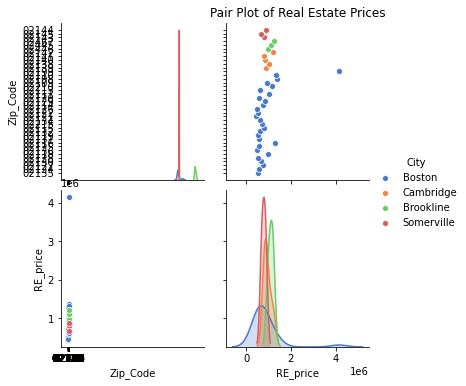

In [7]:
zipcode_eda = zipcodes
sns.set_palette('muted')
sns.pairplot(zipcode_eda[['Zip_Code', 'City', 'RE_price']], hue = 'City')
plt.title('Pair Plot of Real Estate Prices')
plt.savefig('figures/pairplot.png', bbox_inches = 'tight');

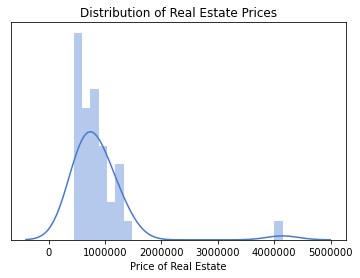

In [8]:
distplot = sns.distplot(zipcode_eda['RE_price'], bins = 25, axlabel = False)
plt.xlabel('Price of Real Estate')
distplot.set(yticks=[])
plt.ticklabel_format(style='plain', axis='x')
plt.title('Distribution of Real Estate Prices')
plt.savefig('figures/distplot.png', bbox_inches = 'tight');

It is clear that the one entry is an extreme outlier which will make modeling and visualization very difficult. The zip code is also very small, as can be seen in the maps further down the page. I will be dropping the entry.

In [9]:
#drop outlier
outlier = zipcode_eda[zipcode_eda['RE_price'] == zipcode_eda['RE_price'].max()].index
zipcode_eda = zipcode_eda.drop(outlier)

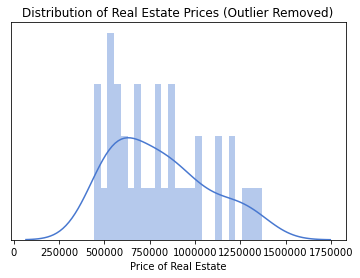

In [10]:
distplot = sns.distplot(zipcode_eda['RE_price'], bins = 25, axlabel = False)
plt.xlabel('Price of Real Estate')
distplot.set(yticks=[])
plt.ticklabel_format(style='plain', axis='x')
plt.title('Distribution of Real Estate Prices (Outlier Removed)')
plt.savefig('figures/distplot_outlier_del.png', bbox_inches = 'tight');

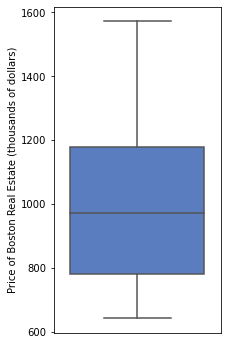

In [11]:
fig, ax = plt.subplots(figsize = (3, 6))
sns.boxplot(data = zipcode_eda, y = 'RE_price')
ax.set(ylabel = 'Price of Boston Real Estate (thousands of dollars)')
ax.set(yticklabels = ['400', '600', '800', '1000', '1200', '1400', '1600'])
ax.set(xticks=[])
plt.savefig('figures/boston_boxplot.png', bbox_inches = 'tight');

By examining the relationship between city and price, it looks to be a worthy selected feature as shown below.

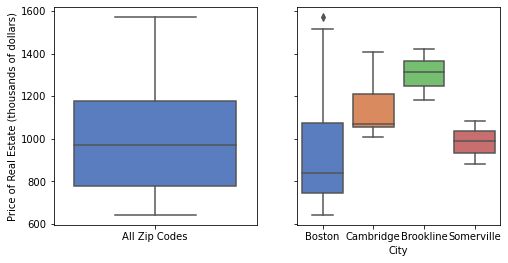

In [12]:
f, axes = plt.subplots(1, 2, sharey = True, figsize = (8, 4))

a = sns.boxplot(data = zipcode_eda, y = 'RE_price', ax = axes[0])
b = sns.boxplot(data = zipcode_eda, y = 'RE_price', x = 'City', ax = axes[1])

a.set(xticklabels=['All Zip Codes'])
a.set(yticklabels=['400', '600', '800', '1000', '1200', '1400', '1600'])
a.set(ylabel='Price of Real Estate (thousands of dollars)')
b.set(ylabel = '')
plt.savefig('figures/boston_boxplot_by_city.png', bbox_inches = 'tight');

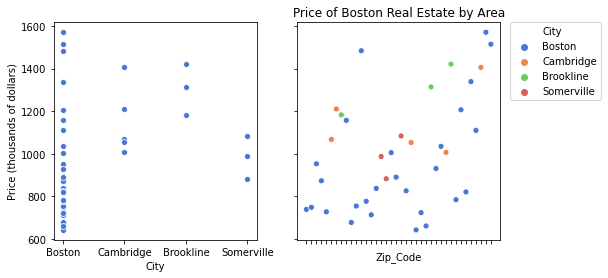

In [13]:
f, axes = plt.subplots(1, 2, sharey = True, figsize = (8, 4))

c = sns.scatterplot(data = zipcode_eda, x = 'City', y = 'RE_price', ax = axes[0]);
d = sns.scatterplot(data = zipcode_eda, x = 'Zip_Code', y = 'RE_price', hue = 'City', ax = axes[1])
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
d.set(xticklabels=[])
c.set(yticklabels=['400', '600', '800', '1000', '1200', '1400', '1600'])
c.set(ylabel = 'Price (thousands of dollars)')
plt.title('Price of Boston Real Estate by Area')
plt.savefig('figures/scatter_by_city.png', bbox_inches = 'tight');

In order to include and calulate the correlation of the city feature, we will be one hot encoding it.

In [14]:
eda_dummies = pd.get_dummies(zipcode_eda['City'])
zipcode_eda = zipcode_eda.merge(eda_dummies, left_index = True, right_index = True)

In [15]:
zipcode_eda.head()

,Zip_Code,City,State,RE_price,Boston,Brookline,Cambridge,Somerville
0,02135,Boston,MA,539527.0,1,0,0,0
1,02124,Boston,MA,549346.0,1,0,0,0
2,02127,Boston,MA,753345.0,1,0,0,0
3,02130,Boston,MA,673592.0,1,0,0,0
4,02128,Boston,MA,528177.0,1,0,0,0


In [16]:
city_correlation = zipcode_eda[['RE_price', 'Boston', 'Brookline', 'Cambridge', 'Somerville']].corr()
city_correlation['RE_price']

RE_price      1.000000
Boston       -0.353669
Brookline     0.341856
Cambridge     0.218391
Somerville   -0.020811
Name: RE_price, dtype: float64

C:\Users\tpacu\miniconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


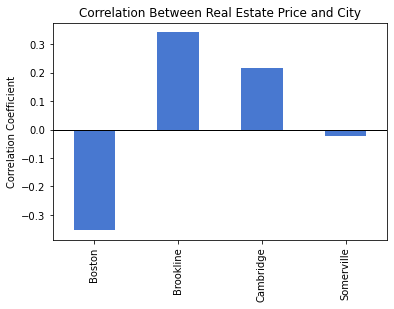

In [17]:
city_correlation['RE_price'][1:].plot.bar()
ax = plt.axes()
ax.axhline(linewidth = 1, color = 'black')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Between Real Estate Price and City')
plt.savefig('figures/city_corr.png', bbox_inches = 'tight');

## Zip Code Information

The following defines a function to return the latitude and longitude coordinates of a given location using Google's GeoCode API. It then pulls the results for all the Boston zip codes in the real estate dataframe, and adds the results to it.

In [18]:
#function to get coordinates of a location using Google's Geocode API
def get_coord(apikey, address):
    try:
        url = 'https://maps.googleapis.com/maps/api/geocode/json?key={}&address={}'.format(apikey, address)
        response = requests.get(url).json()
        geo_location = response['results'][0]['geometry']['location']
        lat, lng = geo_location['lat'], geo_location['lng']
        return [lat, lng]
    except:
        return [None, None]

In [19]:
# get lat, long of boston zip codes

#check for saved files of zipcodes and coordinates
try:
    with open('zipcodes.csv', newline='') as f:
        reader = csv.reader(f)
        zipcode_coordinates = list(reader)

#call API if no file found
except:
    zipcode_coordinates = []
    for zip in zipcodes['Zips']:
        coordinates = get_coord(google_key, zip)
        zipcode_coordinates.append(coordinates)
    with open("zipcodes.csv", "w", newline="") as f: #write call to files
        writer = csv.writer(f)
        writer.writerows(zipcode_coordinates)

print(len(zipcode_coordinates))

39


In [20]:
#parse out data to indivual lists
zc_lat, zc_lng = [], []

for i in range(len(zipcode_coordinates)):
    zc_lat.append(zipcode_coordinates[i][0])
    zc_lng.append(zipcode_coordinates[i][1])

In [21]:
#add into df
zipcodes['Lat'] = zc_lat
zipcodes['Long'] = zc_lng
zipcodes.shape

(39, 6)

In [22]:
zipcodes.head()

,Zip_Code,City,State,RE_price,Lat,Long
0,02135,Boston,MA,539527.0,42.3463503,-71.1626756
1,02124,Boston,MA,549346.0,42.2826027,-71.067605
2,02127,Boston,MA,753345.0,42.3364553,-71.0349193
3,02130,Boston,MA,673592.0,42.3097365,-71.1151431
4,02128,Boston,MA,528177.0,42.3695431,-71.0200613


In order to visualize our zip codes and real estate data on a map, the folium library will be used. First, we will get the coordinates of Boston. Then we will visualize the center of each Boston zip code.

In [23]:
#get boston centerpoint
boston_center = get_coord(google_key, 'Boston, MA')
print(boston_center)

[42.3600825, -71.0588801]


In [24]:
#map boston to check we have the right location
map_boston = folium.Map(location = boston_center, zoom_start = 11)
folium.Marker(boston_center, popup = 'Boston Center').add_to(map_boston)

map_boston

In [25]:
#map the centers of the zip codes of Boston

#feature group of neighborhoods
fg_neighborhoods = folium.map.FeatureGroup()

#add neighborhoods to feature group
for lat, lon, zc in zip(zipcodes['Lat'], zipcodes['Long'], zipcodes['Zip_Code']):
    fg_neighborhoods.add_child(
        folium.CircleMarker(
            [lat, lon],
            radius = 8,
            color = 'blue',
            fill = True,
            popup = zc))
    
#add group and display map

map_boston.add_child(fg_neighborhoods)
map_boston.save('map_boston.html')
map_boston

The next step is to read in a GeoJson file with information for all Massachusetts zip codes. It suffers from the same problem that our earlier zipcodes did, where the id is imported as a float rather than a string. In order to more easily fix this, we read the file into a GeoPandas DataFrame. We first fix the zip code, and then select all the corresponding zip codes for the selected data we already have.

In [26]:
#read geojson of zipcode areas into a geopandas dataframe
ma_geojson = 'ma-zip-codes.geojson'
ma_geo = gpd.read_file(ma_geojson)
ma_geo.head()

,id,geometry
0,1923.0,"POLYGON ((-70.93092 42.61228, -70.92964 42.609..."
1,1960.0,"POLYGON ((-71.00276 42.56336, -71.00085 42.562..."
2,1915.0,"MULTIPOLYGON (((-70.90041 42.59089, -70.89301 ..."
3,2539.0,"MULTIPOLYGON (((-70.55722 41.41547, -70.55820 ..."
4,1037.0,"POLYGON ((-72.12925 42.36566, -72.12931 42.365..."


In [27]:
#id category is supposed to be a five digit zip code, not int
ma_geo['id'] = ma_geo['id'].astype(str) #covert to string
ma_geo['id'] = ma_geo['id'].str.strip(to_strip = '0').str.strip(to_strip = '.') #strip the '.0'
ma_geo['id'] = ma_geo['id'].str.zfill(5) #fill missing first zero
ma_geo.shape

(505, 2)

In [28]:
#select for boston zip codes
zipcodemask = zipcodes['Zip_Code'].tolist()
boston_geo = ma_geo[ma_geo['id'].isin(zipcodemask)]
boston_geo = boston_geo.set_index('id')['geometry']
boston_geo.shape, zipcodes.shape

((39,), (39, 6))

Using the boundaries of each zipcode, we can then generate a custom choropleth map with the price of real estate in each zip code corresponding to the fill color.

In [29]:
#new working map
boston_choro = folium.Map(location = boston_center, zoom_start = 11)

#colormap
bins2 = list(zipcodes['RE_price'].quantile([0, .45, .85, 1]))
linear = cm.LinearColormap(['#fef0d9', '#fdcc8a','#fc8d59', '#d7301f'], vmin = 400000, vmax = 4200000, index = bins2)

#zipcode dictionary
zipcode_dict = zipcodes.set_index('Zip_Code')['RE_price']

#choropleth styling of GeoJson
re_json = folium.GeoJson(
    boston_geo,
    style_function = lambda feature: {
        'fillColor': linear(zipcode_dict[feature['id']]),
        'color': 'black',
        'weight': 2,
        'fillOpacity': .75,
        'highlight': True
        },
    highlight_function = lambda feature: {
        'fillColor': linear(zipcode_dict[feature['id']]),
        'fillOpacity': 1
    }
    )

#create legend
colormap = linear.to_step(25).scale(400,4200)
colormap.caption = 'Price of Residential Real Estate (in thousands of dollars)'

#add choro layer and legend to map
boston_choro.add_child(colormap)
boston_choro.add_child(re_json)

#display map
boston_choro

In [30]:
#drop outlier
outlier = zipcodes[zipcodes['RE_price'] == zipcodes['RE_price'].max()].index
zipcodes = zipcodes.drop(outlier)

## Foursquare Venue Information

The next step is to collect data on venues from Foursquare. Below is a function which retrieves a dataframe the top 100 venues within 750 meters of a latitude and longitude. I then use that function to create a dataframe of all of the venues from each of the zip codes in Boston.

In [31]:
#set foursquare version
version = '20180605'

#function to retrieve venues near a certain location and return in a dataframe
def get_venues(names, lats, longs, radius = 750, limit = 100):
    venues = []
    for name, lat, long, in zip(names, lats, longs):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, client_secret, version, lat, long, radius, limit)
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues.append([(name, lat, long, result['venue']['name'],
                        result['venue']['location']['lat'],
                        result['venue']['location']['lng'],
                        result['venue']['categories'][0]['name']) for result in results])
    venue_df = pd.DataFrame([item for venue_list in venues for item in venue_list])
    venue_df.columns = ['Zip_Code', 
                  'Zip_Latitude', 
                  'Zip_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    return venue_df      
    

In [32]:
#create lists of info to call Foursquare API with
zipcode_list = zipcodes['Zip_Code'].tolist()
zipcode_lats = zipcodes['Lat'].tolist()
zipcode_longs = zipcodes['Long'].tolist()

print(len(zipcode_list), len(zipcode_lats), len(zipcode_longs))

38 38 38


In [34]:
#make call to foursquare using the above function and lists of zip code coordinates

#check and read in csv of previous call if possible
try:
    with open('zipcode_venues.csv') as f:
        df_venues = pd.read_csv(f)
#make call
except:
    zipcode_venues = get_venues(zipcode_list, zipcode_lats, zipcode_longs)
    zipcode_venues.to_csv('zipcode_venues.csv') #write to file

zipcode_venues.head()

,Zip_Code,Zip_Latitude,Zip_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,02135,42.3463503,-71.1626756,Rogers Park,42.347021,-71.166849,Park
1,02135,42.3463503,-71.1626756,Twelve Hours,42.349803,-71.164385,Chinese Restaurant
2,02135,42.3463503,-71.1626756,Charles River Greenway,42.350841,-71.167246,Trail
3,02135,42.3463503,-71.1626756,Energize,42.350444,-71.167959,Vegetarian / Vegan Restaurant
4,02135,42.3463503,-71.1626756,Hoshi Ya Sushi,42.349064,-71.162941,Sushi Restaurant


In [35]:
#unique categories
print('Unique Categories: ', len(zipcode_venues['Venue_Category'].unique()))

Unique Categories:  294


The next step is to normalize the results. In order to normalize the category locations for frequency, it's necesarry to hot one encode each location, as performed below. That can then be grouped and divided for the overall frequency of each category.

In [36]:
#one hot encode the 290 unique categories
zipcode_onehot = pd.get_dummies(zipcode_venues[['Venue_Category']], prefix = '', prefix_sep = '')
zipcode_onehot.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
#create new dataframe with zip code and frequency of categories in each
zipcode_onehot['Zip_Code'] = zipcode_venues['Zip_Code']
zipcode_grouped = zipcode_onehot.groupby('Zip_Code').mean().reset_index()
zipcode_grouped.head(15)

,Zip_Code,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Video Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,02108,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.020000,...,0.0,0.000000,0.0,0.000000,0.010000,0.0,0.00,0.000000,0.000000,0.000000
1,02109,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.010526,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.010526,0.000000,0.000000
2,02110,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.030000,...,0.0,0.000000,0.0,0.000000,0.010000,0.0,0.00,0.010000,0.000000,0.000000
3,02111,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.010000,...,0.0,0.010000,0.0,0.010000,0.010000,0.0,0.00,0.000000,0.000000,0.000000
4,02113,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.020000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.010000,0.000000,0.000000
5,02114,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.040000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.010000,0.000000,0.000000
6,02115,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.013699,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000
7,02116,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.040000,...,0.0,0.000000,0.0,0.000000,0.020000,0.0,0.02,0.000000,0.000000,0.000000
8,02118,0.0,0.010526,0.0,0.010526,0.0,0.0,0.0,0.0,0.042105,...,0.0,0.000000,0.0,0.021053,0.010526,0.0,0.00,0.010526,0.000000,0.000000
9,02119,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000


Next, we will examine the most frequent type of venue in each zip code. In order to do that, the below function will parse the frequencies dataframe and return the results for each zip code. The dataframe of results is below that.

In [38]:
#write a function to return most frequent venues
def get_frequent_venues(row, top_num):
    venue_categories = row.iloc[1:]
    sorted_categories = venue_categories.sort_values(ascending = False)[0:top_num]
    return sorted_categories.index.values

In [39]:
#create a dataframe with zipcode and the top 10 most frequent category for each
top_cats = 10

#creating df columns
columns = ['Zip_Code']
columns2 = ['Category_{}'.format(i+1) for i in range(top_cats)]
columns = columns + columns2
zipcode_categories_sorted = pd.DataFrame(columns = columns)

#add zipcodes and city
zipcode_categories_sorted['Zip_Code'] = zipcode_grouped['Zip_Code']

#add sorted categories
for i in range(len(zipcode_grouped)):
    zipcode_categories_sorted.iloc[i, 1:] = get_frequent_venues(zipcode_grouped.iloc[i, :], top_cats)
    
zipcode_categories_sorted.head()

,Zip_Code,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Category_7,Category_8,Category_9,Category_10
0,02108,Pizza Place,Italian Restaurant,Coffee Shop,Asian Restaurant,Park,Theater,Gym / Fitness Center,Sandwich Place,Spa,Hotel
1,02109,Italian Restaurant,Boat or Ferry,Harbor / Marina,Park,Pizza Place,Seafood Restaurant,Café,Sandwich Place,Bakery,Bar
2,02110,Italian Restaurant,Seafood Restaurant,Park,Sandwich Place,Bar,Bakery,Historic Site,Pizza Place,Hotel,American Restaurant
3,02111,Coffee Shop,Chinese Restaurant,Asian Restaurant,Bakery,Sandwich Place,Park,Performing Arts Venue,Seafood Restaurant,Theater,Gym / Fitness Center
4,02113,Italian Restaurant,Seafood Restaurant,Park,Pizza Place,Historic Site,Coffee Shop,Bakery,Hotel,Sandwich Place,Café


## K-Means Clustering

All of this data for each zip code seems like a candidate for an unsupervised machine learning method. Maybe it is possible to group these zip codes together based upon the type of venues most often found or not found. I have chosen to explore the problem with K-Means.

Since K-Means requires the user to select the number of clusters, that is the first step. Below, I have run the algorithm using a range of clusters between two and ten, and then graphed their silhouette scores below.

In [40]:
#select features
cities = ['Boston', 'Cambridge', 'Somerville', 'Brookline']
zip_clusters = zipcode_grouped.drop('Zip_Code', axis = 1).merge(zipcode_eda[cities], left_index = True, right_index = True)

from sklearn.metrics import silhouette_score

sil = []
kmax = 10

for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(zip_clusters)
    labels = kmeans.labels_
    sil.append(silhouette_score(zip_clusters, labels, metric = 'euclidean'))

Text(0.5, 1.0, 'Silhouette Score per Cluster Size')

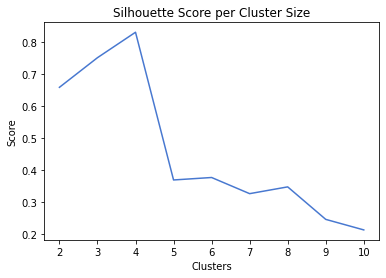

In [41]:
sns.lineplot(x = range(2, kmax+1), y = sil)
plt.xlabel('Clusters')
plt.ylabel('Score')
plt.title('Silhouette Score per Cluster Size')
#plt.savefig('figures/sil_score.png', bbox_inches = 'tight');

As you can see above, four clusters appears to be the best number. I then retrieve the labels for each zip code and add them to the dataframe. 

In [42]:
#cluster zipcodes by frequet categories usig KMeans
clusters = 4

#fit model and check for labels
kmns = KMeans(n_clusters = clusters).fit(zip_clusters)
kmns.labels_[0:5]

array([0, 0, 0, 0, 0])

In [67]:
#create dataframe with zip code info and cluster labels
zipcode_labeled = zipcodes[['Zip_Code', 'Lat', 'Long']]
zipcode_labeled['Cluster_Label'] = kmns.labels_
zipcode_labeled = zipcode_labeled.merge(zipcode_categories_sorted, on = 'Zip_Code')
zipcode_labeled.head()

C:\Users\tpacu\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Zip_Code,Lat,Long,Cluster_Label,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Category_7,Category_8,Category_9,Category_10
0,02135,42.3463503,-71.1626756,0,Pizza Place,Chinese Restaurant,Thai Restaurant,Bakery,Sushi Restaurant,Park,Donut Shop,Bank,Supplement Shop,Bar
1,02124,42.2826027,-71.067605,0,Liquor Store,Donut Shop,Italian Restaurant,Business Service,Gym / Fitness Center,Baseball Field,American Restaurant,Speakeasy,Pizza Place,Plaza
2,02127,42.3364553,-71.0349193,0,Diner,New American Restaurant,Italian Restaurant,Coffee Shop,Convenience Store,Pub,Breakfast Spot,Bar,Pharmacy,American Restaurant
3,02130,42.3097365,-71.1151431,0,Pizza Place,Park,Bakery,Coffee Shop,Donut Shop,Ice Cream Shop,Pub,Art Gallery,Plaza,Bookstore
4,02128,42.3695431,-71.0200613,0,Donut Shop,Coffee Shop,Airport Lounge,Airport,Airport Service,Sandwich Place,Electronics Store,Burger Joint,Seafood Restaurant,Brewery


Let's see what it looks like now on a map, with each zip code colored by real estate price and each zip code grouped according to the K-Means algorithm as run above.

In [44]:
#color markers on map according to label

# create new map
map_clusters = folium.Map(location=boston_center, zoom_start=11)

#add choropleth real estate info
map_clusters.add_child(re_json)
map_clusters.add_child(colormap)

# set color scheme for the clusters
cluster_colors = cm.LinearColormap(['#ffffff', '#000000'], vmin = 0, vmax = clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(zipcode_labeled['Lat'], zipcode_labeled['Long'], zipcode_labeled['Zip_Code'], zipcode_labeled['Cluster_Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster_colors(cluster),
        fill=True,
        fill_color=cluster_colors(cluster),
        fill_opacity=.85).add_to(map_clusters)
       
#add legend for cluster colors
cluster_colormap = cluster_colors.to_step(clusters).scale(1, clusters)
cluster_colormap.caption = 'Cluster Labels'
map_clusters.add_child(cluster_colormap)

map_clusters


Note that the price was not included in the feature selection and is thus independent. It's looking like some of the clusters might have some sort of relationship with the price of real estate. Let's explore the clusters a bit more.

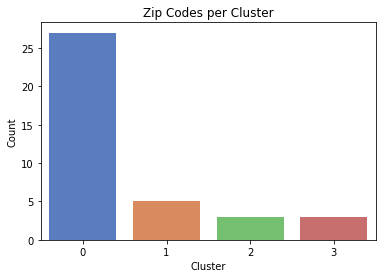

In [45]:
sns.countplot(x = 'Cluster_Label', data = zipcode_labeled)
plt.ylabel('Count')
plt.xlabel('Cluster')
plt.title('Zip Codes per Cluster')
plt.savefig('figures/zips_count_cluster.png', bbox_inches = 'tight');

As you can see, the regions are not distributed evenly which may make our results insignificant, but more on this later. For now, let's take a look at if there are certain venues or types which appear more frequently in a certain cluster. In order to do this, a dataframe needs to be created of frequency of venue grouped by cluster label.

In [68]:
df_countplot = pd.DataFrame()
df_countplot = zipcode_labeled.iloc[:, 3:].merge(zipcodes['City'], left_index = True, right_index = True)
df_countplot = df_countplot.groupby('Cluster_Label').agg({i:'value_counts' for i in df_countplot.columns[1:]}).reset_index()
df_countplot['Total'] = df_countplot.iloc[:, 2:].sum(axis = 1)

nums = []
for n in range(clusters):
    temp = df_countplot['level_0'] == n
    nums.append(len(df_countplot[temp]))

df_countplot['Freq'] = df_countplot.apply(lambda row: row['Total'] / nums[row['level_0']], axis = 1)
df_countplot

,level_0,level_1,Category_1,Category_2,Category_3,Category_4,Category_5,Category_6,Category_7,Category_8,Category_9,Category_10,City,Total,Freq
0,0,Airport,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.010204
1,0,Airport Lounge,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.010204
2,0,Airport Service,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.010204
3,0,American Restaurant,NaN,2.0,NaN,1.0,NaN,NaN,4.0,1.0,NaN,3.0,NaN,11.0,0.112245
4,0,Art Gallery,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,0.010204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,3,Pizza Place,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,3.0,0.125000
186,3,Pub,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,0.041667
187,3,Shoe Store,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.041667
188,3,Somerville,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.125000


In [69]:
#a list of the types of venues that appear more than 5% of the time
df_countplot = df_countplot[df_countplot['Freq'] >= .05]
print(len(df_countplot), df_countplot.level_1.unique())

37 ['American Restaurant' 'Bakery' 'Bar' 'Boston' 'Café' 'Chinese Restaurant'
 'Coffee Shop' 'Convenience Store' 'Donut Shop' 'Hotel'
 'Italian Restaurant' 'Liquor Store' 'Park' 'Pizza Place' 'Pub'
 'Sandwich Place' 'Seafood Restaurant' 'Cambridge' 'Cosmetics Shop'
 'Grocery Store' 'Brookline' 'Indian Restaurant' 'Somerville']


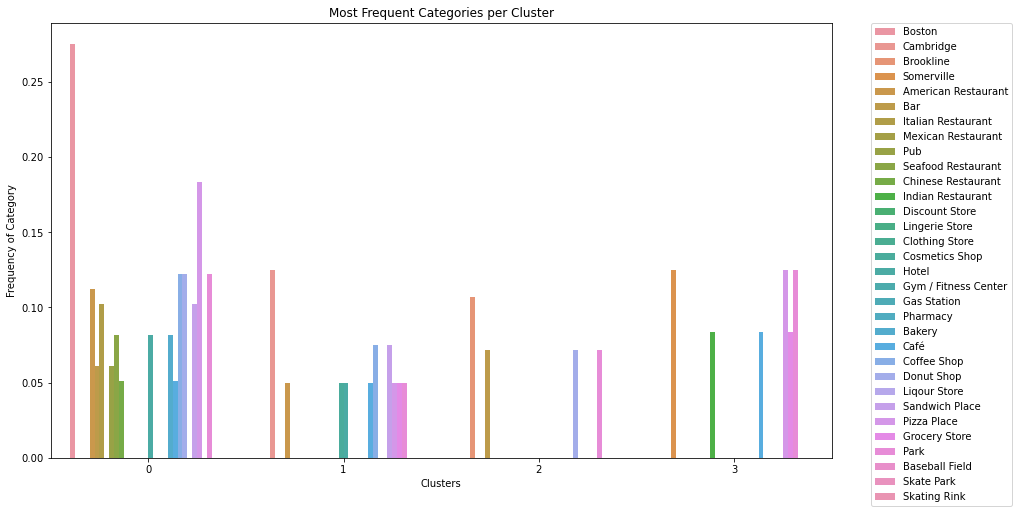

In [70]:
#rough grouping, for visualization's sake, of each broad category

order = ['Boston', 'Cambridge', 'Brookline', 'Somerville', #cities
         'American Restaurant', 'Bar', 'Italian Restaurant', 'Mexican Restaurant',  'Pub', 'Seafood Restaurant', 'Chinese Restaurant', 'Indian Restaurant', #sit-down restaurants
         'Discount Store', 'Lingerie Store', 'Clothing Store', 'Cosmetics Shop', 'Hotel', 'Gym / Fitness Center', 'Gas Station', 'Pharmacy', #retail locations and services
         'Bakery', 'Café', 'Coffee Shop', 'Donut Shop', 'Liqour Store', 'Sandwich Place', 'Pizza Place', 'Grocery Store', #casual restaurants and food     
         'Park', 'Baseball Field', 'Skate Park', 'Skating Rink' #public venues
        ]

fig = plt.subplots(figsize = (14, 8))
sns.barplot(data = df_countplot, x = 'level_0', y = 'Freq', hue = 'level_1', hue_order = order)
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0.)
plt.xlabel('Clusters')
plt.ylabel('Frequency of Category')
plt.title('Most Frequent Categories per Cluster')
plt.savefig('figures/freq_cat_per_cluster.png', bbox_inches = 'tight');

Lastly, let's take a look visually at what we saw on the map earlier, and see what the relationship of zip code and cluster label looks like using a box plot. Of course we need to verify anything we see as statistically signifigant which we will do.

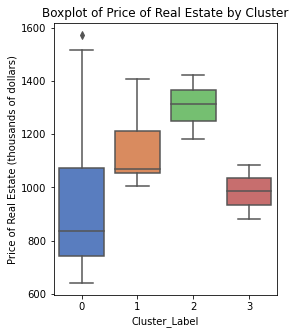

In [50]:
stat_sig = zipcode_labeled[['Zip_Code', 'Cluster_Label']].merge(zipcodes, on = 'Zip_Code')

fig, ax = plt.subplots(figsize = (4, 5))
sns.boxplot(data = stat_sig, x = 'Cluster_Label', y = 'RE_price')
plt.ylabel('Price of Real Estate (thousands of dollars)')
ax.set(yticklabels = ['400', '600', '800', '1000', '1200', '1400', '1600'])
plt.title('Boxplot of Price of Real Estate by Cluster')
plt.savefig('figures/clustered_boxplot.png', bbox_inches = 'tight');

## Modeling and Testing

The first test I am going to run is on the statistic signifigance of the divergence in each K-Means labeled cluster. I will be using an f_oneway test for this.

In [71]:
#dataframe with necesarry information
stat_sig.head(10)

,Zip_Code,Cluster_Label,City,State,RE_price,Lat,Long
0,02135,0,Boston,MA,539527.0,42.3463503,-71.1626756
1,02124,0,Boston,MA,549346.0,42.2826027,-71.067605
2,02127,0,Boston,MA,753345.0,42.3364553,-71.0349193
3,02130,0,Boston,MA,673592.0,42.3097365,-71.1151431
4,02128,0,Boston,MA,528177.0,42.3695431,-71.0200613
5,02139,1,Cambridge,MA,867765.0,42.36475590000001,-71.1032591
6,02138,1,Cambridge,MA,1010497.0,42.3803274,-71.13891009999999
7,02446,2,Brookline,MA,983011.0,42.3421605,-71.1240559
8,02118,0,Boston,MA,957177.0,42.3377967,-71.0705763
9,02136,0,Boston,MA,478330.0,42.2527785,-71.1299976


In [52]:
#seperate out real estate prices by cluster

cluster_0 = np.asarray(stat_sig[stat_sig['Cluster_Label'] == 0]['RE_price'])
cluster_1 = np.asarray(stat_sig[stat_sig['Cluster_Label'] == 1]['RE_price'])
cluster_2 = np.asarray(stat_sig[stat_sig['Cluster_Label'] == 2]['RE_price'])
cluster_3 = np.asarray(stat_sig[stat_sig['Cluster_Label'] == 3]['RE_price'])

In [72]:
#f test
fstat, pval = f_oneway(cluster_0, cluster_1, cluster_2, cluster_3)
print('F Statistic:  {}\nP-Value:  {}'.format(fstat, pval))

F Statistic:  2.583956591229901
P-Value:  0.0693067389824961


The p-value is above .05 so further exploration is unnecesarry.

Next, I am going to try testing out two different models of regression: linear and random forests.

In [54]:
#create dataframe with information to build models

zipcode_reg = stat_sig.merge(zipcode_grouped, on = 'Zip_Code')
zipcode_reg = zipcode_reg.merge(zipcode_eda[cities], left_index = True, right_index = True)
zipcode_reg = zipcode_reg.drop(['City', 'State', 'Lat', 'Long', 'Cluster_Label'], axis = 1)
zipcode_reg.head()

,Zip_Code,RE_price,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,...,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Boston,Cambridge,Somerville,Brookline
0,02135,539527.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.02381,0.0,0.000000,0.0,0.0,1,0,0,0
1,02124,549346.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.0,0.000000,0.0,0.0,1,0,0,0
2,02127,753345.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.0,0.000000,0.0,0.0,1,0,0,0
3,02130,673592.0,0.0,0.030303,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00000,0.0,0.030303,0.0,0.0,1,0,0,0
4,02128,528177.0,0.0,0.000000,0.0,0.0,0.052632,0.070175,0.052632,0.035088,...,0.0,0.00000,0.0,0.000000,0.0,0.0,1,0,0,0


In [55]:
#select all features

X = zipcode_reg.drop(['Zip_Code', 'RE_price'], axis = 1)
Y = zipcode_reg['RE_price']

First, the linear regression model:

In [56]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 0)

regressor = LinearRegression()
regressor.fit(x_train, y_train)

y_hat = regressor.predict(x_test)
regressor.score(x_test, y_test)

0.7490697503654301

This is enccouraging, but let's test it on more than one sample using cross validation.

In [57]:
scores = cross_val_score(regressor, X, Y, cv = 5)
print('All scores:  {} \nMean Score:  {}'.format(scores, scores.mean()))

All scores:  [ 0.51370789  0.73258686 -0.6870599   0.04607873 -0.12491926] 
Mean Score:  0.09607886532503329


This means that on average, only 9.6% of the variance can be explained by the model - a thoroughly unexciting number. You can also see the variance in score which signifies a small sample size.

Next, I will try with the random forest regression model.

In [58]:
forest_reg = RandomForestRegressor()
forest_reg.fit(x_train, y_train)

forest_y_hat = forest_reg.predict(x_test)
forest_reg.score(x_test, y_test)

0.5517792877770926

Again, not a bad place to start, but as we saw above this might not mean anything. Let's cross validate.

In [59]:
forest_scores = cross_val_score(forest_reg, X, Y, cv = 5)
print('All scores:  {} \nMean Score:  {}'.format(forest_scores, forest_scores.mean()))

All scores:  [ 0.06277592  0.00506398 -0.43158977  0.07662241 -1.82563318] 
Mean Score:  -0.4225521280972018


Same problems as above.

Alright, let's try selecting features then instead of giving the models the entire dataset. To do this, I will run a correlation test and then we can use the most highly correlated variables (both negative and positive).

In [60]:
corr_df = zipcode_reg.corr()
corr_df['RE_price'].sort_values(ascending = False)

RE_price                1.000000
French Restaurant       0.570607
Wine Shop               0.523369
Steakhouse              0.475007
Spa                     0.446101
                          ...   
Discount Store         -0.361027
Fast Food Restaurant   -0.402975
Donut Shop             -0.409556
Pharmacy               -0.489445
Pizza Place            -0.507934
Name: RE_price, Length: 299, dtype: float64

Ok, let's select the features and run cross validation tests.

In [61]:
features = ['French Restaurant', 'Salad Place', 'Wine Shop', 'Dessert Shop', 'Fast Food Restaurant', 'Donut Shop', 'Pharmacy', 'Pizza Place']
X_selected = zipcode_reg[features]

For the linear regression model:

In [62]:
scores_sel = cross_val_score(regressor, X_selected, Y, cv = 5)
print('All Scores:  {}\nMean Score:  {}'.format(scores_sel, scores_sel.mean()))

All Scores:  [ 0.63580283  0.66184224 -0.71351347  0.74642144 -0.11765406]
Mean Score:  0.24257979447064404


And then the random forest model:

In [63]:
forest_scores_sel = cross_val_score(forest_reg, X_selected, Y, cv = 5)
print('All Scores:  {}\nMean Score:  {}'.format(forest_scores_sel, forest_scores_sel.mean()))

All Scores:  [ 0.02902893  0.09692026 -0.3504714   0.51072515 -0.60327882]
Mean Score:  -0.06341517375033826


Same issues as above. Sample size is simply too small for meaningful modeling.